# Assignment 6: Apply NB

<ol>
    <li>Minimum data points need to be considered for people having 4GB RAM is <strong>50k</strong> and for 8GB RAM is <strong>100k</strong></li>
    <li>When you are using ramdomsearchcv or gridsearchcv you need not split the data into X_train,X_cv,X_test. As the above methods use kfold. The model will learn better if train data is more so splitting to X_train,X_test will suffice.</li>
    <li>If you are writing for loops to tune your model then you need split the data into X_train,X_cv,X_test.</li>
    <li>While splitting the data explore stratify parameter. </li>
    <li><strong>Apply Multinomial NB on these feature sets</strong></li>
        <ul>
            <li>Features that need to be considered</li> 
                <dl>
                  <dt>essay</dt>
                    <dd>while encoding essay, try to experiment with the max_features and n_grams parameter of vectorizers and see if it increases AUC score.</dd>
                  <dt>categorical features</dt>
                  <dd> - teacher_prefix</dd>
                  <dd> - project_grade_category</dd>
                  <dd> - school_state</dd>
                  <dd> - clean_categories</dd>
                  <dd> - clean_subcategories</dd>
                  <dt>numerical features</dt>
                  <dd> - price</dd>
                  <dd> - teacher_number_of_previously_posted_projects</dd>
                  <dd>while encoding the numerical features check <a href='https://imgur.com/ldZA1zg'>this</a> and <a href='https://ac-classroom-production.s3.amazonaws.com/public/COMMENT/Annotation_2020-05-21_225912_0lyZzN8.jpg'>this</a></dd>
                </dl>    
            <li><font color='red'>Set 1</font>: categorical, numerical features + preprocessed_eassay (BOW)</li>
            <li><font color='red'>Set 2</font>: categorical, numerical features + preprocessed_eassay (TFIDF)</li>
        </ul>
    <li><strong>The hyper paramter tuning(find best alpha:smoothing parameter)</strong>
        <ul>
    <li>Consider alpha values in range: 10^-5 to 10^2 like [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]</li>
    <li>Explore class_prior = [0.5, 0.5] parameter which can be present in MultinomialNB function(go through <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>this</a> ) then check how results might change.
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>For hyper parameter tuning using k-fold cross validation(use GridsearchCV or RandomsearchCV)/simple cross validation data (write for loop to iterate over hyper parameter values)</li>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/hUv6aEy.jpg' width=300px><dd>-while plotting take log(alpha) on your X-axis so that it will be more readable</dd></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://imgur.com/q2P65L5.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
        <img src='https://i.imgur.com/IdN5Ctv.png' width=300px><dd>-plot the confusion matrix in heatmaps, while plotting the confusion matrix go through the <a href='https://stackoverflow.com/questions/61748441/how-to-fix-the-values-displayed-in-a-confusion-matrix-in-exponential-form-to-nor'>link </a>
</dd></li>
        </ul>
<li>find the top 20 features from either from feature <font color='red'>Set 1</font> or feature <font color='red'>Set 2</font> using values of `feature_log_prob_ ` parameter of `MultinomialNB` 
(https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) and print <strong>BOTH</strong> positive as well as negative corresponding feature names. <dd> - go through the <a href='https://imgur.com/mWvE7gj'>link </a> </dd>
    </li>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

In [4]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

import re


import pickle
from tqdm import tqdm
import os

from chart_studio import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

<h1>2. Naive Bayes </h1>

## 1.1 Loading Data

In [5]:
import pandas
data = pandas.read_csv('preprocessed_data.csv',nrows=100000)
data.head(5)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00
3,ga,mrs,grades_prek_2,2,1,appliedlearning,earlydevelopment,i recently read article giving students choice...,481.04
4,wa,mrs,grades_3_5,2,1,literacy_language,literacy,my students crave challenge eat obstacles brea...,17.74


<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [6]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label    
X = data.drop('project_is_approved',axis=1)     
Y = data['project_is_approved'].values

from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.33,stratify=Y)
X_train,X_cv,Y_train,Y_cv = train_test_split(X_train,Y_train,test_size=0.33,stratify=Y_train)
print("no.of train - ",len(X_train))   
print("no. of test - ",len(X_test))
print("no. of cross_val - ",len(X_cv))

no.of train -  44890
no. of test -  33000
no. of cross_val -  22110


<h2>1.3 Make Data Model Ready: encoding eassay, and project_title</h2>

<h3> SET 1 - ESSAY using BOW </h3>

In [102]:
print('before vectorization')
print("train -",X_train.shape)
print("test -",X_test.shape)
print("C_V -",X_cv.shape)

vectorizer_ess = CountVectorizer(min_df=10,ngram_range=(1,4),max_features=10000)
vectorizer_ess.fit(X_train['essay'].values)
X_train_essay_BOW = vectorizer_ess.transform(X_train['essay'].values)
X_test_essay_BOW = vectorizer_ess.transform(X_test['essay'].values)
X_cv_essay_BOW = vectorizer_ess.transform(X_cv['essay'].values)

print("After vectorization")
print(X_train_essay_BOW.shape, Y_train.shape)
print(X_cv_essay_BOW.shape, Y_cv.shape)
print(X_test_essay_BOW.shape, Y_test.shape)

before vectorization
train - (44890, 8)
test - (33000, 8)
C_V - (22110, 8)
After vectorization
(44890, 10000) (44890,)
(22110, 10000) (22110,)
(33000, 10000) (33000,)


<h3> SET 2 - ESSAY using TFIDF </h3>

In [103]:
from sklearn.feature_extraction.text import TfidfVectorizer


print('before vectorization')
print("train -",X_train.shape)
print("test -",X_test.shape)
print("C_V -",X_cv.shape)

vectorizer_ess_2 = TfidfVectorizer(min_df=10,ngram_range=(1,4),max_features=10000)
vectorizer_ess_2.fit(X_train['essay'].values)
X_train_essay_TFIDF = vectorizer_ess_2.transform(X_train['essay'].values)
X_test_essay_TFIDF = vectorizer_ess_2.transform(X_test['essay'].values)
X_cv_essay_TFIDF = vectorizer_ess_2.transform(X_cv['essay'].values)

print("After vectorization")
print(X_train_essay_TFIDF.shape, Y_train.shape)
print(X_cv_essay_TFIDF.shape, Y_cv.shape)
print(X_test_essay_TFIDF.shape, Y_test.shape)

before vectorization
train - (44890, 8)
test - (33000, 8)
C_V - (22110, 8)
After vectorization
(44890, 10000) (44890,)
(22110, 10000) (22110,)
(33000, 10000) (33000,)


<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

<h4>encoding categorical features: School State</h4>

In [8]:
vectorizer_st = CountVectorizer()
vectorizer_st.fit(X_train['school_state'].values) 

X_train_state_ohe = vectorizer_st.transform(X_train['school_state'].values)
X_cv_state_ohe = vectorizer_st.transform(X_cv['school_state'].values)
X_test_state_ohe = vectorizer_st.transform(X_test['school_state'].values)

print("After vectorization")
print(X_train_state_ohe.shape, Y_train.shape)
print(X_cv_state_ohe.shape, Y_cv.shape)
print(X_test_state_ohe.shape, Y_test.shape)
print(vectorizer_st.get_feature_names())


After vectorization
(44890, 51) (44890,)
(22110, 51) (22110,)
(33000, 51) (33000,)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']


<h4>encoding categorical features: teacher_prefix</h4>

In [9]:
vectorizer_tp = CountVectorizer()
vectorizer_tp.fit(X_train['teacher_prefix'].values)

# we use the fitted CountVectorizer to convert the text to vector
X_train_teacher_ohe = vectorizer_tp.transform(X_train['teacher_prefix'].values)
X_cv_teacher_ohe = vectorizer_tp.transform(X_cv['teacher_prefix'].values)
X_test_teacher_ohe = vectorizer_tp.transform(X_test['teacher_prefix'].values)

print("After vectorization")
print(X_train_teacher_ohe.shape, Y_train.shape)
print(X_cv_teacher_ohe.shape, Y_cv.shape)
print(X_test_teacher_ohe.shape, Y_test.shape)
print(vectorizer_tp.get_feature_names())


After vectorization
(44890, 5) (44890,)
(22110, 5) (22110,)
(33000, 5) (33000,)
['dr', 'mr', 'mrs', 'ms', 'teacher']


<h4>encoding categorical features: project_grade_category</h4>

In [10]:
vectorizer_gc = CountVectorizer()
vectorizer_gc.fit(X_train['project_grade_category'].values) 

X_train_grade_ohe = vectorizer_gc.transform(X_train['project_grade_category'].values)
X_cv_grade_ohe = vectorizer_gc.transform(X_cv['project_grade_category'].values)
X_test_grade_ohe = vectorizer_gc.transform(X_test['project_grade_category'].values)

print("After vectorization")
print(X_train_grade_ohe.shape, Y_train.shape)
print(X_cv_grade_ohe.shape, Y_cv.shape)
print(X_test_grade_ohe.shape, Y_test.shape)
print(vectorizer_gc.get_feature_names())


After vectorization
(44890, 4) (44890,)
(22110, 4) (22110,)
(33000, 4) (33000,)
['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']


<h4>encoding categorical features: clean_categories</h4>

In [11]:
vectorizer_cc = CountVectorizer()
vectorizer_cc.fit(X_train['clean_categories'].values) 

X_train_categories_ohe = vectorizer_cc.transform(X_train['clean_categories'].values)
X_cv_categories_ohe = vectorizer_cc.transform(X_cv['clean_categories'].values)
X_test_categories_ohe = vectorizer_cc.transform(X_test['clean_categories'].values)

print("After vectorization")
print(X_train_categories_ohe.shape, Y_train.shape)
print(X_cv_categories_ohe.shape, Y_cv.shape)
print(X_test_categories_ohe.shape, Y_test.shape)
print(vectorizer_cc.get_feature_names())


After vectorization
(44890, 9) (44890,)
(22110, 9) (22110,)
(33000, 9) (33000,)
['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds', 'warmth']


<h4>encoding categorical features: clean_subcategories</h4>

In [12]:
vectorizer_csc = CountVectorizer()
vectorizer_csc.fit(X_train['clean_subcategories'].values) 

X_train_subcategories_ohe = vectorizer_csc.transform(X_train['clean_subcategories'].values)
X_cv_subcategories_ohe = vectorizer_csc.transform(X_cv['clean_subcategories'].values)
X_test_subcategories_ohe = vectorizer_csc.transform(X_test['clean_subcategories'].values)

print("After vectorization")
print(X_train_subcategories_ohe.shape, Y_train.shape)
print(X_cv_subcategories_ohe.shape, Y_cv.shape)
print(X_test_subcategories_ohe.shape, Y_test.shape)
print(vectorizer_csc.get_feature_names())


After vectorization
(44890, 30) (44890,)
(22110, 30) (22110,)
(33000, 30) (33000,)
['appliedsciences', 'care_hunger', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'environmentalscience', 'esl', 'extracurricular', 'financialliteracy', 'foreignlanguages', 'gym_fitness', 'health_lifescience', 'health_wellness', 'history_geography', 'literacy', 'literature_writing', 'mathematics', 'music', 'nutritioneducation', 'other', 'parentinvolvement', 'performingarts', 'socialsciences', 'specialneeds', 'teamsports', 'visualarts', 'warmth']


<h4>encoding numerical features: Price</h4>

In [13]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
normalizer.fit(X_train['price'].values.reshape(1,-1))  ## edited when lstm assignemnt do reshape(-1,1)

X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(1,-1))   # array shape changed to 1 row many columns
X_cv_price_norm = normalizer.transform(X_cv['price'].values.reshape(1,-1))
X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(1,-1))

X_train_price_std = X_train_price_norm.reshape(-1,1)   # reshaping array to many rows and 1 column
X_cv_price_std    = X_cv_price_norm.reshape(-1,1)
X_test_price_std  = X_test_price_norm.reshape(-1,1)
print("After vectorization, shape of X and Y data - train,cv,test in order")
print(X_train_price_std.shape, Y_train.shape)
print(X_cv_price_std.shape, Y_cv.shape)
print(X_test_price_std.shape, Y_test.shape)

ValueError: X has 22110 features, but Normalizer is expecting 44890 features as input.

<h4>encoding numerical features: teacher_number_of_previously_posted_projects</h4>

In [110]:
normalizer = Normalizer()
normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

X_train_prev_posted_norm = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))   # array shape changed to 1 row many columns
X_cv_prev_posted_norm = normalizer.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
X_test_prev_posted_norm = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

X_train_prev_posted_std = X_train_prev_posted_norm.reshape(-1,1)   # reshaping array to many rows and 1 column
X_cv_prev_posted_std    = X_cv_prev_posted_norm.reshape(-1,1)
X_test_prev_posted_std  = X_test_prev_posted_norm.reshape(-1,1)

print("After vectorization, shape of X and Y data - train,cv,test in order")
print(X_train_prev_posted_std.shape, Y_train.shape)
print(X_cv_prev_posted_std.shape, Y_cv.shape)
print(X_test_prev_posted_std.shape, Y_test.shape)


After vectorization, shape of X and Y data - train,cv,test in order
(44890, 1) (44890,)
(22110, 1) (22110,)
(33000, 1) (33000,)


 <h2>Concatinating all the features</h2>

<h3>Set 1: categorical, numerical features + preprocessed_eassay (BOW)</h3>

In [111]:
from scipy.sparse import hstack

X_tr_set_1 = hstack((X_train_essay_BOW, X_train_state_ohe, X_train_teacher_ohe, X_train_grade_ohe,X_train_categories_ohe,X_train_subcategories_ohe, X_train_price_std,X_train_prev_posted_std)).tocsr()
X_cr_set_1 = hstack((X_cv_essay_BOW, X_cv_state_ohe, X_cv_teacher_ohe, X_cv_grade_ohe,X_cv_categories_ohe,X_cv_subcategories_ohe, X_cv_price_std,X_cv_prev_posted_std)).tocsr()
X_te_set_1 = hstack((X_test_essay_BOW, X_test_state_ohe, X_test_teacher_ohe, X_test_grade_ohe,X_test_categories_ohe,X_test_subcategories_ohe, X_test_price_std,X_test_prev_posted_std)).tocsr()

print("Final Data matrix")
print(X_tr_set_1.shape, Y_train.shape)
print(X_cr_set_1.shape, Y_cv.shape)
print(X_te_set_1.shape, Y_test.shape)


Final Data matrix
(44890, 10101) (44890,)
(22110, 10101) (22110,)
(33000, 10101) (33000,)


<h3> Set 2: categorical, numerical features + preprocessed_eassay (TFIDF)</h3>

In [112]:
X_tr_set_2 = hstack((X_train_essay_TFIDF, X_train_state_ohe, X_train_teacher_ohe, X_train_grade_ohe,X_train_categories_ohe,X_train_subcategories_ohe, X_train_price_std,X_train_prev_posted_std)).tocsr()
X_cr_set_2 = hstack((X_cv_essay_TFIDF, X_cv_state_ohe, X_cv_teacher_ohe, X_cv_grade_ohe,X_cv_categories_ohe,X_cv_subcategories_ohe, X_cv_price_std,X_cv_prev_posted_std)).tocsr()
X_te_set_2 = hstack((X_test_essay_TFIDF, X_test_state_ohe, X_test_teacher_ohe, X_test_grade_ohe,X_test_categories_ohe,X_test_subcategories_ohe, X_test_price_std,X_test_prev_posted_std)).tocsr()

print("Final Data matrix")
print(X_tr_set_2.shape, Y_train.shape)
print(X_cr_set_2.shape, Y_cv.shape)
print(X_te_set_2.shape, Y_test.shape)


Final Data matrix
(44890, 10101) (44890,)
(22110, 10101) (22110,)
(33000, 10101) (33000,)


<h2>1.5 Appling NB on different kind of featurization as mentioned in the instructions</h2>
<h3>SET-1</h3>


####  Hyper parameter Tuning 

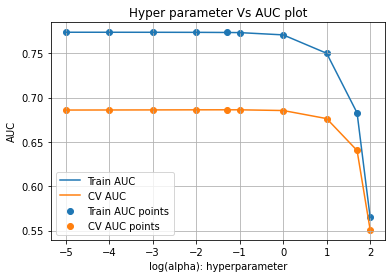

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
7,0.053189,0.000857,0.015728,5.199170e-04,1e-05,{'alpha': 1e-05},0.690211,0.697682,0.670087,0.685993,0.011654,6,0.772039,0.776684,0.772601,0.773775,0.002070
3,0.051353,0.000468,0.015328,4.662004e-04,0.0001,{'alpha': 0.0001},0.690270,0.697815,0.670086,0.686057,0.011706,5,0.772020,0.776655,0.772601,0.773759,0.002061
5,0.052015,0.000001,0.015000,1.348699e-06,0.001,{'alpha': 0.001},0.690333,0.697996,0.670086,0.686138,0.011774,4,0.771988,0.776605,0.772599,0.773731,0.002047
1,0.052681,0.001248,0.015336,4.706964e-04,0.01,{'alpha': 0.01},0.690399,0.698224,0.670074,0.686233,0.011864,3,0.771921,0.776505,0.772573,0.773666,0.002025
4,0.052347,0.000472,0.015170,2.401248e-04,0.05,{'alpha': 0.05},0.690436,0.698362,0.670016,0.686271,0.011941,1,0.771766,0.776317,0.772463,0.773515,0.002001
8,0.052679,0.000471,0.015002,7.370010e-07,0.1,{'alpha': 0.1},0.690437,0.698381,0.669939,0.686252,0.011983,2,0.771603,0.776132,0.772322,0.773352,0.001987
0,0.055642,0.003680,0.017632,3.719712e-03,1,{'alpha': 1},0.690307,0.697465,0.668583,0.685452,0.012281,7,0.769042,0.773415,0.769937,0.770798,0.001886
2,0.052680,0.000943,0.015002,1.123916e-07,10,{'alpha': 10},0.686063,0.685867,0.657068,0.676333,0.013623,8,0.747384,0.751998,0.750694,0.750025,0.001942
6,0.052852,0.000628,0.015334,4.718761e-04,50,{'alpha': 50},0.653712,0.642556,0.624806,0.640358,0.011903,9,0.677090,0.682489,0.688799,0.682793,0.004785
9,0.053349,0.000945,0.014235,3.188983e-04,100,{'alpha': 100},0.555294,0.547263,0.549658,0.550738,0.003367,10,0.562668,0.562614,0.569011,0.564764,0.003003


In [113]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RandomizedSearchCV
from math import log
MNB = MultinomialNB(class_prior=[0.5, 0.5])
parameters = {'alpha': [0.00001, 0.0001,0.001,0.05,0.01,0.1,1,5,10,50,100] }        # giving alpha values between 10^-5 to 10^2
clf= RandomizedSearchCV(MNB,parameters,cv=3,scoring='roc_auc',return_train_score=True)   
clf.fit(X_tr_set_1,Y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)

results = results.sort_values(['param_alpha'])


train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
a =  results['param_alpha']
a=[log(y,10) for y in a]
plt.plot(a, train_auc, label='Train AUC')
plt.plot(a, cv_auc, label='CV AUC')
plt.scatter(a, train_auc, label='Train AUC points')
plt.scatter(a, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("log(alpha): hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()

results

In [114]:
clf.best_params_    # BEST alpha VALUE

{'alpha': 0.05}

In [115]:
best_alpha = 0.05

####  Testing the performance of the model on test data, plotting ROC Curves

In [116]:
def batch_predict(clf, data):


    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000

    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])

    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1]) 
    
    return y_data_pred

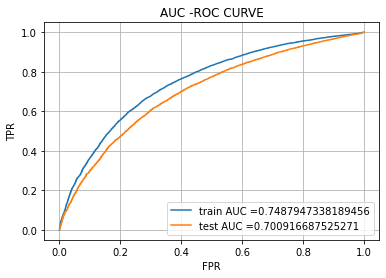

In [117]:
#  PERFORM Multinomial Naive Bayes with Best alpha value

from sklearn.metrics import roc_curve, auc

MNB = MultinomialNB(alpha=best_alpha,class_prior=[0.5, 0.5])
MNB.fit(X_tr_set_1,Y_train)

y_train_pred = batch_predict(MNB,X_tr_set_1)
y_test_pred = batch_predict(MNB,X_te_set_1)

train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("AUC -ROC CURVE")
plt.grid()
plt.show()

In [118]:
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [120]:
from sklearn.metrics import confusion_matrix

best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

print("Train confusion matrix")
conf_mat_train = confusion_matrix(Y_train, predict_with_best_t(y_train_pred, best_t))
print(conf_mat_train)
print("Test confusion matrix")
conf_mat_test = confusion_matrix(Y_test, predict_with_best_t(y_test_pred, best_t))
print(conf_mat_test)

the maximum value of tpr*(1-fpr) 0.4760774961706644 for threshold 0.564
Train confusion matrix
[[ 4838  1978]
 [12537 25537]]
Test confusion matrix
[[ 3218  1792]
 [ 9493 18497]]


<AxesSubplot:>

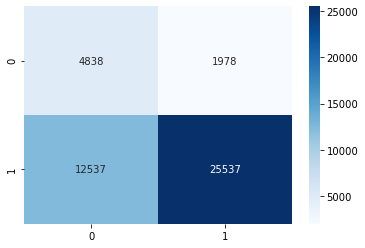

In [121]:
import seaborn as sns
import matplotlib.pyplot as plt     

sns.heatmap(conf_mat_train, annot=True,fmt="d",cmap='Blues')

<AxesSubplot:>

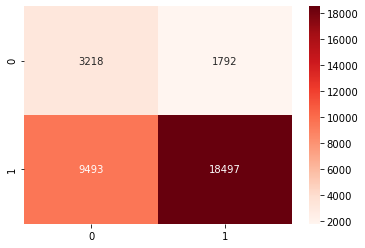

In [122]:
sns.heatmap(conf_mat_test , annot=True ,fmt='d' ,cmap='Reds')

<h3>SET-2 </h3>

####  Hyper parameter Tuning 

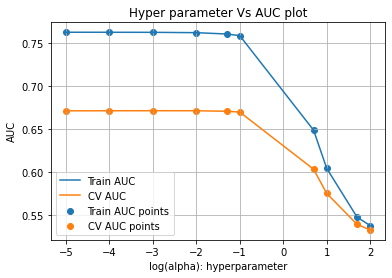

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
9,0.046878,0.000002,0.020557,6.864999e-03,1e-05,{'alpha': 1e-05},0.676232,0.680037,0.656508,0.670926,0.010312,4,0.762037,0.765595,0.759577,0.762403,0.002470
4,12.642128,17.812364,0.020828,7.357210e-03,0.0001,{'alpha': 0.0001},0.676269,0.680210,0.656506,0.670995,0.010371,3,0.762005,0.765553,0.759574,0.762377,0.002455
1,0.048817,0.002609,0.013420,3.161949e-03,0.001,{'alpha': 0.001},0.676304,0.680412,0.656487,0.671068,0.010445,1,0.761924,0.765456,0.759540,0.762307,0.002430
5,0.047374,0.000701,0.015626,3.893359e-07,0.01,{'alpha': 0.01},0.676270,0.680502,0.656289,0.671020,0.010559,2,0.761519,0.765004,0.759197,0.761907,0.002386
2,0.051112,0.002987,0.015880,1.045579e-02,0.05,{'alpha': 0.05},0.675920,0.679872,0.655403,0.670399,0.010725,5,0.759979,0.763370,0.757702,0.760351,0.002329
6,0.046872,0.000008,0.017001,1.944318e-03,0.1,{'alpha': 0.1},0.675411,0.678889,0.654306,0.669536,0.010862,6,0.758146,0.761438,0.755878,0.758487,0.002283
8,0.057292,0.007363,0.010417,7.366145e-03,5,{'alpha': 5},0.615059,0.604104,0.589651,0.602938,0.010405,7,0.642626,0.649091,0.653590,0.648435,0.004500
7,0.052584,0.007042,0.015627,1.215701e-06,10,{'alpha': 10},0.585519,0.573645,0.565434,0.574866,0.008245,8,0.597443,0.603981,0.610702,0.604042,0.005413
0,0.052320,0.003871,0.015146,8.129606e-04,50,{'alpha': 50},0.545462,0.537945,0.532850,0.538752,0.005180,9,0.542315,0.547166,0.551960,0.547147,0.003937
3,0.048258,0.006225,0.014657,1.159201e-02,100,{'alpha': 100},0.538389,0.532282,0.526233,0.532301,0.004963,10,0.533057,0.537048,0.542003,0.537369,0.003659


In [123]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RandomizedSearchCV
from math import log
MNB = MultinomialNB(class_prior=[0.5, 0.5])
parameters = {'alpha': [0.00001, 0.0001,0.001,0.05,0.01,0.1,1,5,10,50,100] }
clf_2= RandomizedSearchCV(MNB,parameters,cv=3,scoring='roc_auc',return_train_score=True)
clf_2.fit(X_tr_set_2,Y_train)

results_2 = pd.DataFrame.from_dict(clf_2.cv_results_)

results_2 = results_2.sort_values(['param_alpha'])


train_auc_2= results_2['mean_train_score']
train_auc_std_2= results_2['std_train_score']
cv_auc_2 = results_2['mean_test_score'] 
cv_auc_std_2= results_2['std_test_score']
a_2 =  results_2['param_alpha']
a_2=[log(y,10) for y in a_2]
plt.plot(a_2, train_auc_2, label='Train AUC')
plt.plot(a_2, cv_auc_2, label='CV AUC')
plt.scatter(a_2, train_auc_2, label='Train AUC points')
plt.scatter(a_2, cv_auc_2, label='CV AUC points')

plt.legend()
plt.xlabel("log(alpha): hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()

results_2

In [124]:
clf_2.best_params_

{'alpha': 0.001}

In [125]:
best_alpha_2 = 0.001

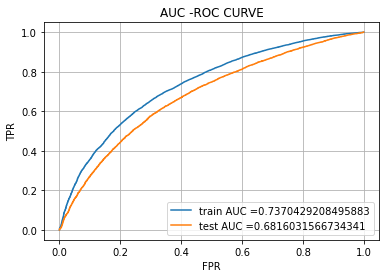

In [126]:
from sklearn.metrics import roc_curve, auc

MNB = MultinomialNB(alpha=best_alpha_2,class_prior=[0.5, 0.5])
MNB.fit(X_tr_set_2,Y_train)

y_train_pred_2 = batch_predict(MNB,X_tr_set_2)
y_test_pred_2 = batch_predict(MNB,X_te_set_2)

train_fpr_2, train_tpr_2, tr_thresholds_2 = roc_curve(Y_train, y_train_pred_2)
test_fpr_2, test_tpr_2, te_thresholds_2 = roc_curve(Y_test, y_test_pred_2)

plt.plot(train_fpr_2, train_tpr_2, label="train AUC ="+str(auc(train_fpr_2, train_tpr_2)))
plt.plot(test_fpr_2, test_tpr_2, label="test AUC ="+str(auc(test_fpr_2, test_tpr_2)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("AUC -ROC CURVE")
plt.grid()
plt.show()

Confusion Matrix

In [127]:
from sklearn.metrics import confusion_matrix

best_t_2 = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

print("Train confusion matrix")
conf_mat_train_2 = confusion_matrix(Y_train, predict_with_best_t(y_train_pred_2, best_t_2))
print(conf_mat_train_2)
print("Test confusion matrix")
conf_mat_test_2 = confusion_matrix(Y_test, predict_with_best_t(y_test_pred_2, best_t_2))
print(conf_mat_test_2)

the maximum value of tpr*(1-fpr) 0.4760774961706644 for threshold 0.564
Train confusion matrix
[[ 5367  1449]
 [17103 20971]]
Test confusion matrix
[[ 3641  1369]
 [12898 15092]]


<AxesSubplot:>

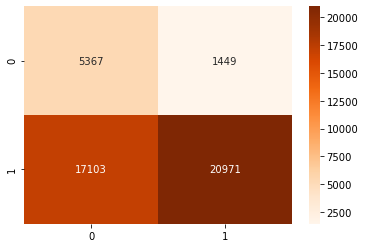

In [128]:
import seaborn as sns
import matplotlib.pyplot as plt     

sns.heatmap(conf_mat_train_2, annot=True,fmt="d",cmap='Oranges')

<AxesSubplot:>

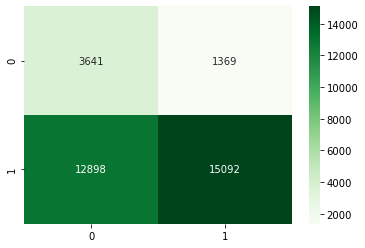

In [129]:
sns.heatmap(conf_mat_test_2, annot=True,fmt="d",cmap='Greens')

<h3>TOP 20 FEATURES</h3>

In [130]:
feature_names=[]
feature_names.extend(vectorizer_st.get_feature_names())
feature_names.extend(vectorizer_tp.get_feature_names())
feature_names.extend(vectorizer_gc.get_feature_names())
feature_names.extend(vectorizer_cc.get_feature_names())
feature_names.extend(vectorizer_csc.get_feature_names())
feature_names.extend(vectorizer_ess.get_feature_names())
feature_names.append('Price')
feature_names.append('teacher_number_of_previously_posted_projects')
len(feature_names)

10101

In [131]:
proba_neg = MNB.feature_log_prob_[0]
#print(proba_neg)
proba_pos = MNB.feature_log_prob_[1]
#print(proba_pos)

sorted_proba_neg = np.argsort(proba_neg)
sorted_proba_neg = np.flipud(sorted_proba_neg)
top_20_neg = sorted_proba_neg[0:19]
print("Indices of TOP 20 featues for negative class : ",top_20_neg)

sorted_proba_pos = np.argsort(proba_pos)
sorted_proba_pos = np.flipud(sorted_proba_pos)
top_20_pos = sorted_proba_pos[0:19]
print("\nIndices of Top 20 features for positive class : ",top_20_pos)

Indices of TOP 20 featues for negative class :  [10053 10064 10059 10065 10054 10056 10088 10086 10087 10057 10004 10062
 10095 10067 10060 10069  7826 10058 10052]

Indices of Top 20 features for positive class :  [10053 10064 10059 10065 10054 10056 10086 10088 10087 10057 10004 10062
 10095 10067  7826 10060 10084 10058 10052]


In [132]:
print("TOP 20 featues for negative class : ")
for i in top_20_neg:
    print(feature_names[i])
print("\nTop 20 features for positive class : ")
for j in top_20_pos:
    print(feature_names[j])

TOP 20 featues for negative class : 
year would
yes
years come
yet
year would like
yearbook
your donation
youngest
your
years
would provide
years students
your support
yoga ball
years come nannan
yoga mats
stem science technology
years ago
year we

Top 20 features for positive class : 
year would
yes
years come
yet
year would like
yearbook
youngest
your donation
your
years
would provide
years students
your support
yoga ball
stem science technology
years come nannan
younger siblings
years ago
year we


<h1>3. Summary</h1>

<br> as mentioned in the step 5 of instructions

In [133]:
from prettytable import PrettyTable 

myTable = PrettyTable(["Vectorizer", "Model", "Hyperparameter", "AUC"])
myTable.add_row(["BOW", "Naive Bayes", best_alpha, auc(test_fpr, test_tpr)]) 
myTable.add_row(["TFIDF", "Naive Bayes", best_alpha_2, auc(test_fpr_2, test_tpr_2)]) 
print(myTable)

+------------+-------------+----------------+--------------------+
| Vectorizer |    Model    | Hyperparameter |        AUC         |
+------------+-------------+----------------+--------------------+
|    BOW     | Naive Bayes |      0.05      | 0.700916687525271  |
|   TFIDF    | Naive Bayes |     0.001      | 0.6816031566734341 |
+------------+-------------+----------------+--------------------+
